In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
from kmeans import KMeans
import argparse
sns.set(style='ticks', palette='Set2')

CONVERGENCE_DELTA = 1e-6
MAXIMUM_ITERATIONS = 100

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [17]:
class KMeans():
    def __init__(
        self,
        x_train,
        y_train,
        num_clusters=3,
        seed: str = "random",
    ):
        self.dataset = x_train
        self.targets = y_train
        self.k = num_clusters
        self.num_features = x_train.shape[1]
        self.num_samples = x_train.shape[0]
        if seed == "random":
            self.centroids = self.random_initialise_centroids()
        elif seed == "custom":
            self.centroids = self.initialise_from_data()
        else:
            raise ValueError("Choose a seed between ['random', 'custom']") 
        self.old_centroids = np.copy(self.centroids)
        self.cluster_labels = np.zeros(self.num_samples, dtype=int)
        for i in range(self.num_samples):
            self.cluster_labels[i] = np.argmin(
                np.linalg.norm(self.dataset[i]-self.centroids, ord=2, axis=1))

        
    def random_initialise_centroids(self):
        mean = np.mean(self.dataset, axis = 0)
        std = np.std(self.dataset, axis = 0)
        return np.random.randn(self.k, self.num_features)*std + mean
        return centroids
    
    def initialise_from_data(self):
        centroids = np.copy(self.dataset[np.random.choice(
                self.num_samples, self.k, replace=(False if self.k <= self.num_samples else True))])
        return centroids 
        
    def get_centroid_labels(self):
        centroid_labels = np.zeros(self.k)
        for i in range(self.k):
            count = np.bincount(self.targets[self.cluster_labels == i])
            if len(count) > 0:
                centroid_labels[i] = np.argmax(count)
        return centroid_labels
    
    def calculate_loss(self):
        loss = np.mean(np.linalg.norm(
            self.dataset - self.centroids[self.cluster_labels], ord=2, axis=1), axis=0)
        return loss
    
    def fit(self):
        for i in range(MAXIMUM_ITERATIONS):
            for i in range(self.num_samples):
                self.cluster_labels[i] = np.argmin(
                    np.linalg.norm(self.dataset[i]-self.centroids, ord=2, axis=1))
            prev_centers = np.copy(self.centroids)
            converged = True
            for i in range(self.k):
                alloted = self.dataset[self.cluster_labels == i]
                if len(alloted) > 0:
                    self.centroids[i] = np.mean(alloted, axis=0)
                else:
                    self.centroids[i] = np.zeros(self.num_features)
                if np.linalg.norm(prev_centers[i] - self.centroids[i]) > CONVERGENCE_DELTA:
                    converged = False
            loss = self.calculate_loss()
            if converged is True:
                print(f"TOTAL ITERATIONS = {i}")
                break
            self.old_centroids = np.copy(self.centroids)

    def predict(self, x):
        labels = np.zeros(x.shape[0], dtype=int)
        for i in range(x.shape[0]):
            labels[i] = np.argmin(
                np.linalg.norm(x[i]-self.centroids, ord=2, axis=1))
        return self.get_centroid_labels()[labels]

In [18]:
def load_train_data(data_size=100):
    (x_train, y_train), (_, _) = mnist.load_data()
    x_train = x_train / 255
    x_train = x_train.reshape(x_train.shape[0], -1)
    digits = []
    targets = []
    for i in range(10):
        images = x_train[y_train == i]
        digits.append(images[np.random.choice(
            len(images), data_size, replace=False)])
        targets.append(np.full((data_size,), i))
    x_train = np.vstack(digits)
    y_train = np.hstack(targets)
    permutation = np.random.permutation(x_train.shape[0])
    x_train = x_train[permutation]
    y_train = y_train[permutation]
    return x_train, y_train

def load_test_data(data_size=50):
    (_, _), (x_test, y_test) = mnist.load_data()
    x_test = x_test / 255
    x_test = x_test.reshape(x_test.shape[0], -1)
    test_indices = np.random.choice(x_test.shape[0], data_size)
    x_test = x_test[test_indices]
    y_test = y_test[test_indices]
    return (x_test, y_test)

def plot_cluster_representatives(kmeans, centroids):
    centroid_images = np.copy(centroids.reshape(kmeans.k, 28, 28))
    centroid_images = centroid_images * 255
    centroid_labels = kmeans.get_centroid_labels()
    fig = plt.figure(figsize=(15, 15))
    nrows = 5
    ncols = 4
    for i in range(kmeans.k):
        fig.add_subplot(nrows, ncols, i+1)
        plt.imshow(centroid_images[i], cmap="gray")
        plt.title(f"Cluster Number {i+1}\nCluster Representative: {centroid_labels[i]}", fontsize=10)
        plt.axis("off")
    fig.tight_layout()
    plt.show()


def k_means_mnist(num_clusters=20, seed="random"):
    (x_train, y_train) = load_train_data()
    (x_test, y_test) = load_test_data()
    kmeans = KMeans(x_train, y_train,
                    num_clusters=num_clusters,
                    seed=seed)
    kmeans.fit()  
    predictions = kmeans.predict(x_test)
    acc = np.mean(predictions == y_test)
    print(f"Accuracy: {acc}") 
    plot_cluster_representatives(kmeans, kmeans.centroids)  
    

def multiple_k_clusters(min_k = 0, max_k = 20, seed="random"):
    k = np.arange(start=min_k, stop=max_k+1, step=1, dtype=int)
    (x_train, y_train) = load_train_data()
    (x_test, y_test) = load_test_data()
    jclust = []
    accuracy = []
    for num_clusters in k:
        print("---------------------------")
        print(f"K = {num_clusters}")
        kmeans = KMeans(x_train, y_train,
                        num_clusters=num_clusters,
                        seed=seed)
        kmeans.fit()
        loss = kmeans.calculate_loss()
        print(f"TOTAL LOSS = {loss}")
        jclust.append(loss)
        predictions = kmeans.predict(x_test)
        acc = np.mean(predictions == y_test)
        print(f"Accuracy = {acc}\n")
        accuracy.append(acc)
    
    plt.plot(k, jclust)
    plt.title("J-clustering loss with number of clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("J-Clustering Loss")
    plt.show()
    
    plt.plot(k, accuracy)
    plt.title("Test set accuracy with number of clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Accuracy on test set")
    plt.show()

In [19]:
random.seed(70)
np.random.seed(70)

TOTAL ITERATIONS = 24
Accuracy: 0.56


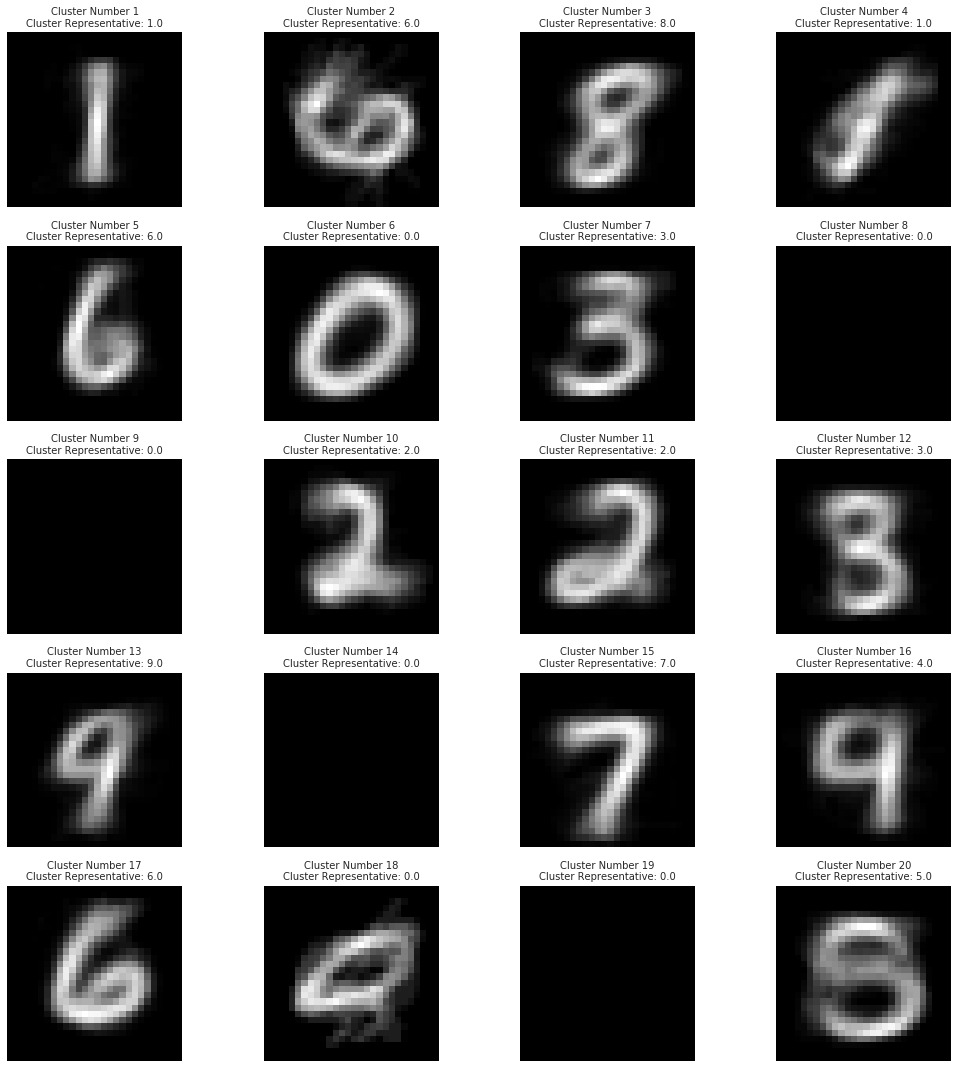

In [16]:
k_means_mnist(seed = "random")

TOTAL ITERATIONS = 19
Accuracy: 0.72


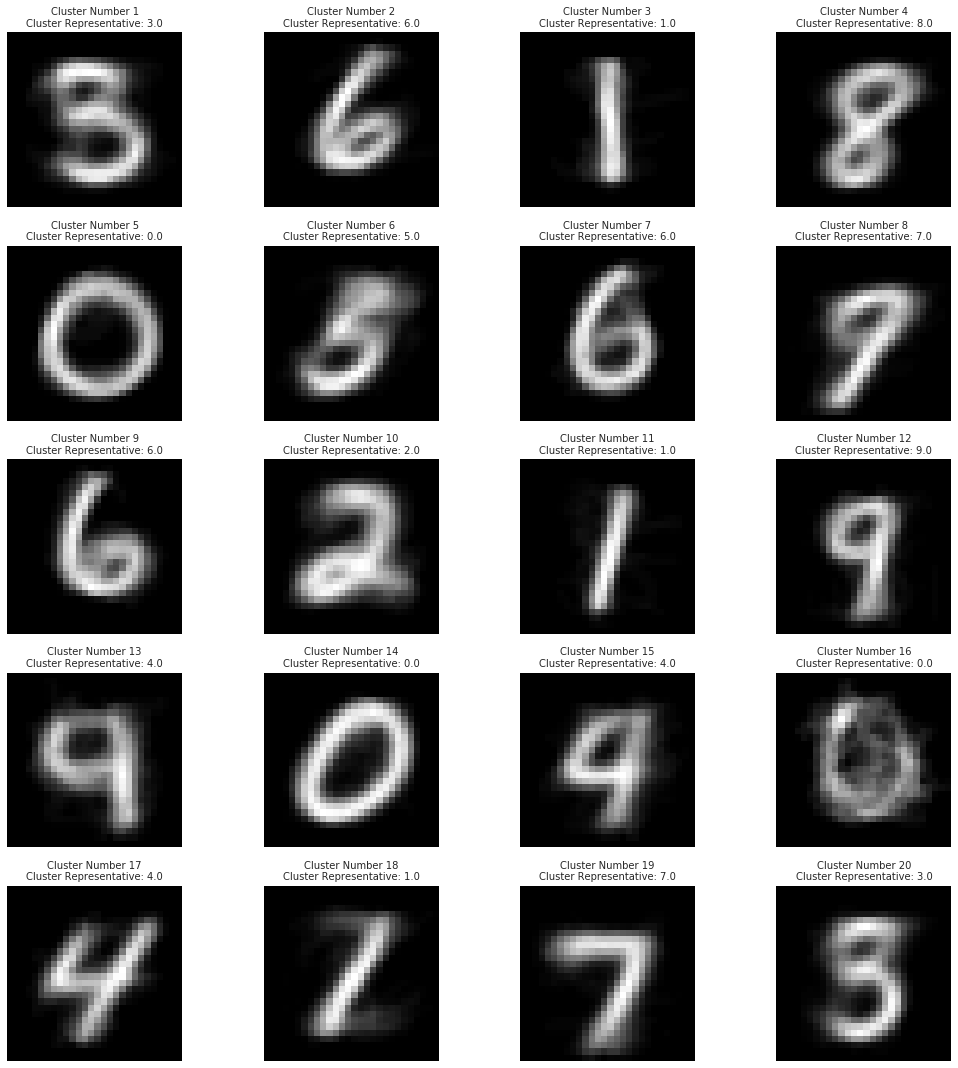

In [20]:
k_means_mnist(seed = "custom")

---------------------------
K = 5
TOTAL ITERATIONS = 4
TOTAL LOSS = 6.50840838105185
Accuracy = 0.52

---------------------------
K = 6
TOTAL ITERATIONS = 5
TOTAL LOSS = 6.425665301537582
Accuracy = 0.54

---------------------------
K = 7
TOTAL ITERATIONS = 6
TOTAL LOSS = 6.396683941105112
Accuracy = 0.48

---------------------------
K = 8
TOTAL ITERATIONS = 7
TOTAL LOSS = 6.287688655285234
Accuracy = 0.6

---------------------------
K = 9
TOTAL ITERATIONS = 8
TOTAL LOSS = 6.236148643261253
Accuracy = 0.58

---------------------------
K = 10
TOTAL ITERATIONS = 9
TOTAL LOSS = 6.175016030542126
Accuracy = 0.7

---------------------------
K = 11
TOTAL ITERATIONS = 10
TOTAL LOSS = 6.139282865923727
Accuracy = 0.66

---------------------------
K = 12
TOTAL ITERATIONS = 11
TOTAL LOSS = 6.083365536633343
Accuracy = 0.72

---------------------------
K = 13
TOTAL ITERATIONS = 12
TOTAL LOSS = 6.016859778564274
Accuracy = 0.7

---------------------------
K = 14
TOTAL ITERATIONS = 13
TOTAL LOSS = 

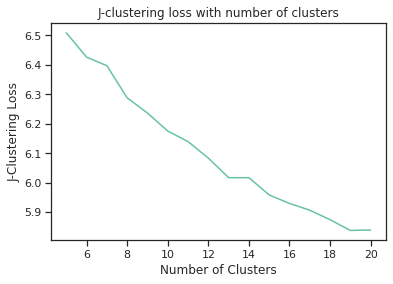

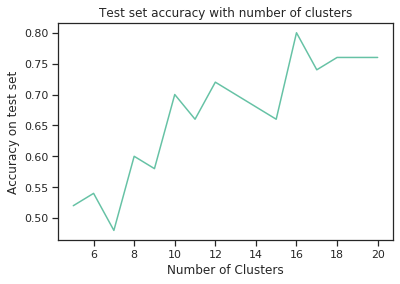

In [21]:
multiple_k_clusters(min_k = 5, max_k = 20, seed = "custom")

---------------------------
K = 5
TOTAL ITERATIONS = 4
TOTAL LOSS = 6.5714835430122145
Accuracy = 0.4

---------------------------
K = 6
TOTAL ITERATIONS = 5
TOTAL LOSS = 6.454241270053107
Accuracy = 0.44

---------------------------
K = 7
TOTAL ITERATIONS = 6
TOTAL LOSS = 6.389698213233495
Accuracy = 0.46

---------------------------
K = 8
TOTAL ITERATIONS = 7
TOTAL LOSS = 6.325797242161661
Accuracy = 0.5

---------------------------
K = 9
TOTAL ITERATIONS = 8
TOTAL LOSS = 6.249483032309927
Accuracy = 0.56

---------------------------
K = 10
TOTAL ITERATIONS = 9
TOTAL LOSS = 6.211009299439668
Accuracy = 0.52

---------------------------
K = 11
TOTAL ITERATIONS = 10
TOTAL LOSS = 6.165129442672038
Accuracy = 0.54

---------------------------
K = 12
TOTAL ITERATIONS = 11
TOTAL LOSS = 6.112581756168993
Accuracy = 0.54

---------------------------
K = 13
TOTAL ITERATIONS = 12
TOTAL LOSS = 6.071516260660529
Accuracy = 0.68

---------------------------
K = 14
TOTAL ITERATIONS = 13
TOTAL LOSS

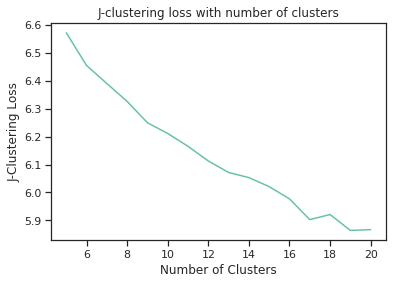

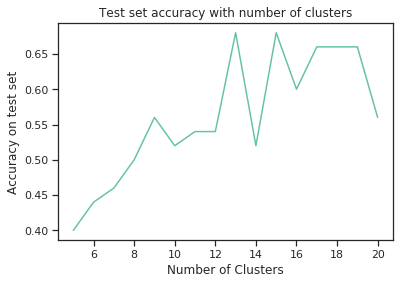

In [22]:
multiple_k_clusters(min_k = 5, max_k = 20, seed = "random")